# 캐글 집값 예측하기

## 참고할 Data fields   
ID : 집을 구분하는 번호   
date : 집을 구매한 날짜   
price : 집의 가격(Target variable)   
bedrooms : 침실의 수   
bathrooms : 화장실의 수   
sqft_living : 주거 공간의 평방 피트(면적)   
sqft_lot : 부지의 평방 피트(면적)   
floors : 집의 층 수   
waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)   
view : 집이 얼마나 좋아 보이는지의 정도   
condition : 집의 전반적인 상태   
grade : King County grading 시스템 기준으로 매긴 집의 등급   
sqft_above : 지하실을 제외한 평방 피트(면적)   
sqft_basement : 지하실의 평방 피트(면적)   
yr_built : 지어진 년도   
yr_renovated : 집을 재건축한 년도   
zipcode : 우편번호   
lat : 위도   
long : 경도   
sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)   
sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)   

# 데이터 불러오기

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
from os.path import join
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/AI_study/Exploration/E05_kaggle_house_price_prediction/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

data = pd.read_csv(train_data_path)
sub = pd.read_csv(test_data_path)

print(train_data_path)
print(test_data_path)
print(data.shape)
print(sub.shape)

/aiffel/aiffel/AI_study/Exploration/E05_kaggle_house_price_prediction/data/train.csv
/aiffel/aiffel/AI_study/Exploration/E05_kaggle_house_price_prediction/data/test.csv
(15035, 21)
(6468, 20)


# 데이터 전처리

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [4]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             6468 non-null   int64  
 1   date           6468 non-null   object 
 2   bedrooms       6468 non-null   int64  
 3   bathrooms      6468 non-null   float64
 4   sqft_living    6468 non-null   int64  
 5   sqft_lot       6468 non-null   int64  
 6   floors         6468 non-null   float64
 7   waterfront     6468 non-null   int64  
 8   view           6468 non-null   int64  
 9   condition      6468 non-null   int64  
 10  grade          6468 non-null   int64  
 11  sqft_above     6468 non-null   int64  
 12  sqft_basement  6468 non-null   int64  
 13  yr_built       6468 non-null   int64  
 14  yr_renovated   6468 non-null   int64  
 15  zipcode        6468 non-null   int64  
 16  lat            6468 non-null   float64
 17  long           6468 non-null   float64
 18  sqft_liv

sub는 당연하게도 price 데이터가 없다. 따로 저장해두고 전처리 작업 진행하기 위해 합쳐주자

In [5]:
# data의 price를 y 변수에 두고 price column 삭제
y = data['price']

del data['price']

# train과 sub data 합치기
# 나중에 train data만 따로 부르기 위해 length를 추출해뒀다
train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))

21503


In [6]:
# 결측치 확인
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [7]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [8]:
# id 정리와 data 깔끔하게 만들기
sub_id = data['id'][train_len:]
del data['id']

data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(int)

In [9]:
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 변수들 분포도 확인 후 정규화

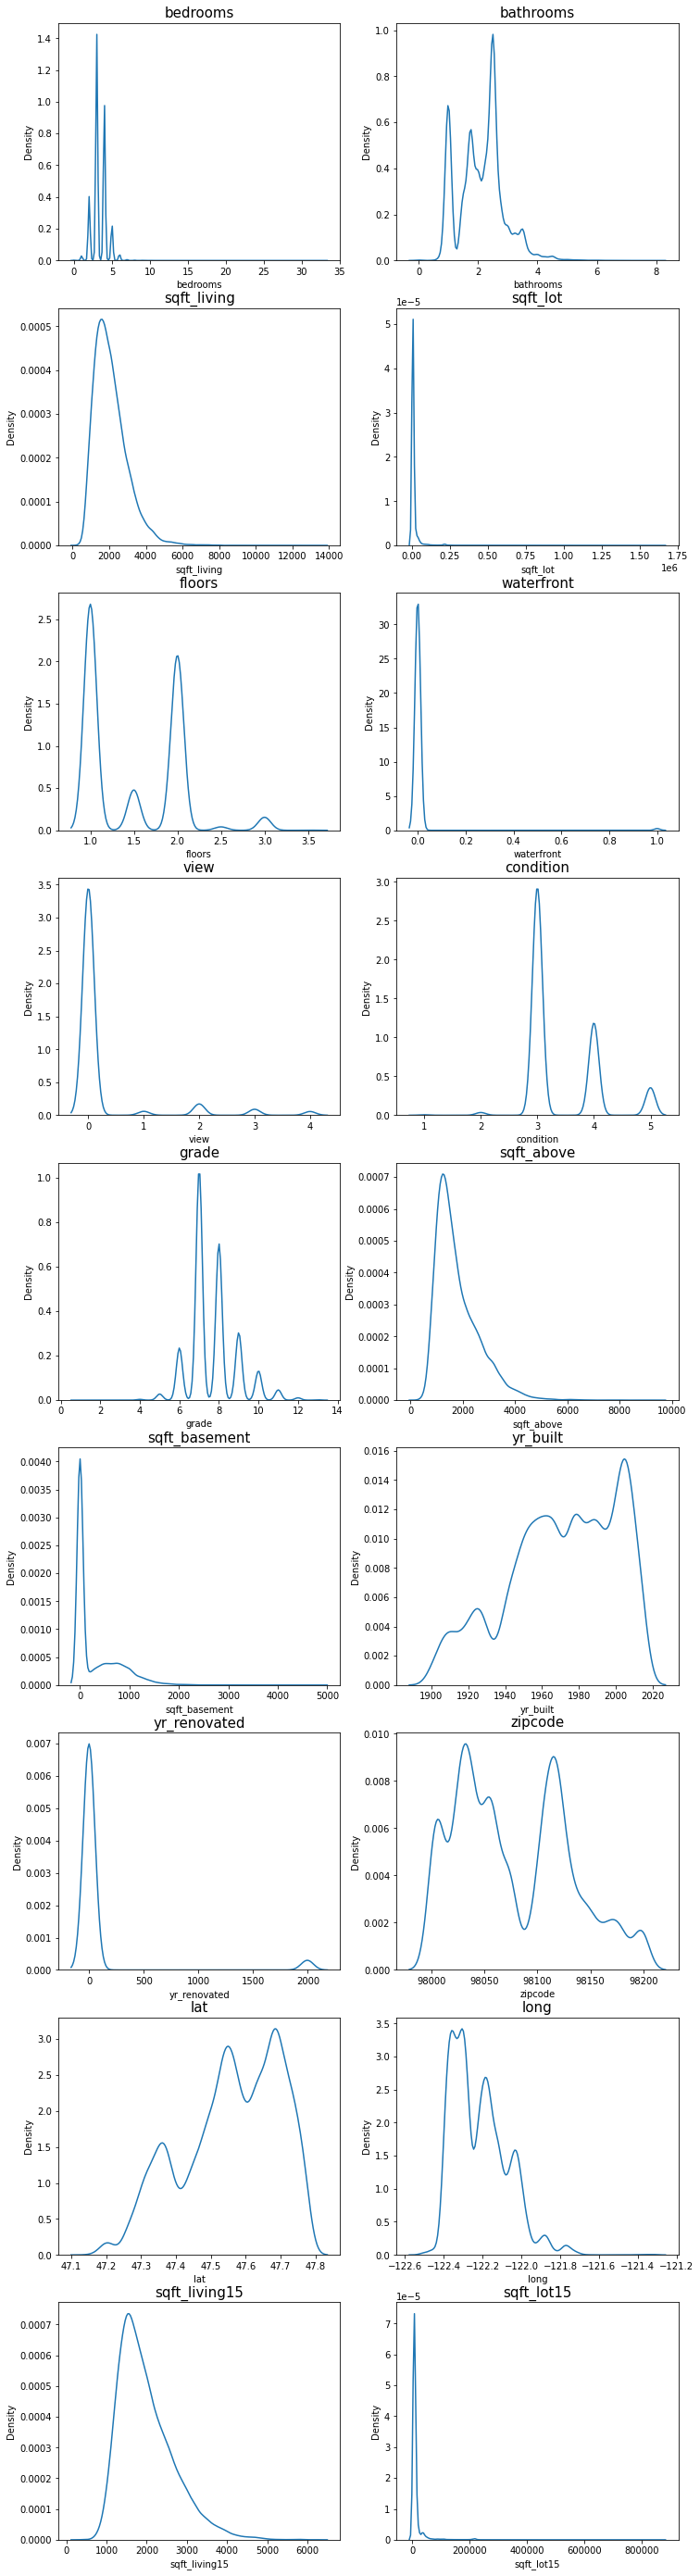

In [10]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))

count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

In [11]:
# 그래프가 한쪽으로 치우친 변수들을 np.log1p()를 통해 정규분포에 근접하게 만들기.
skew_columns = [
    'bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15'
]

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

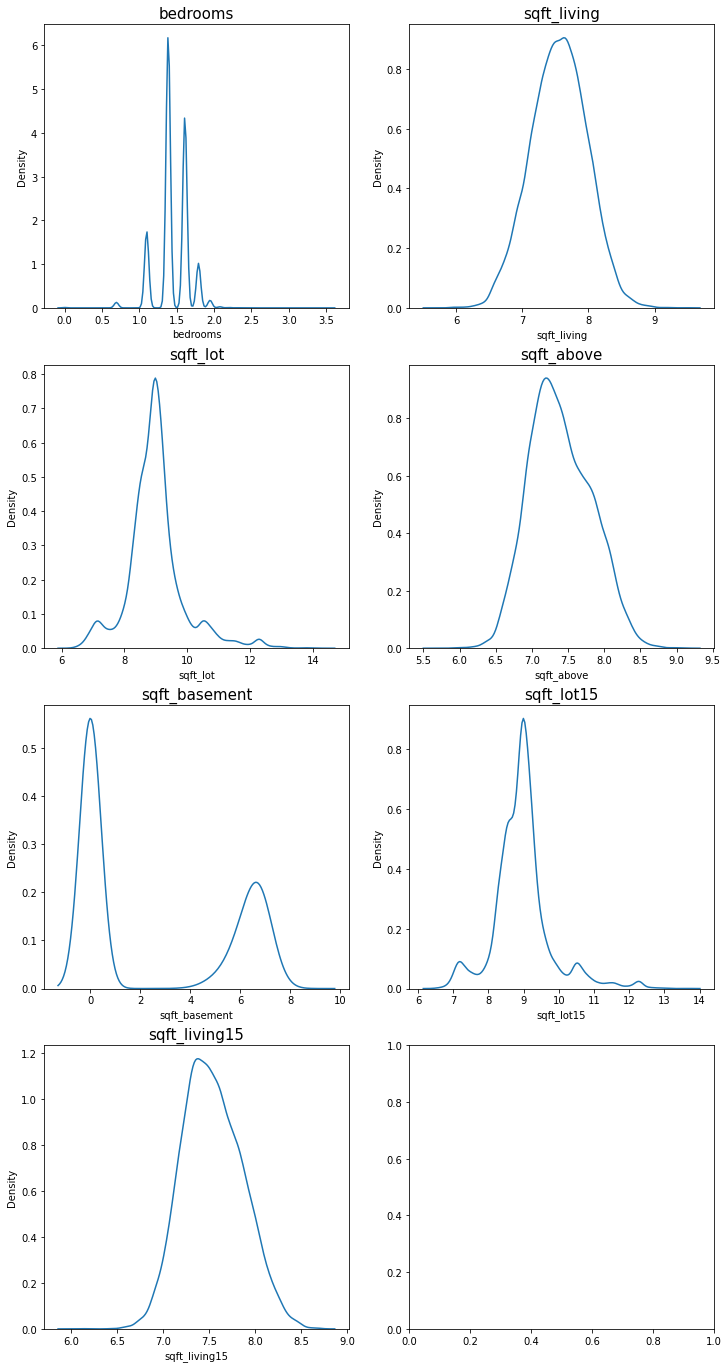

In [12]:
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

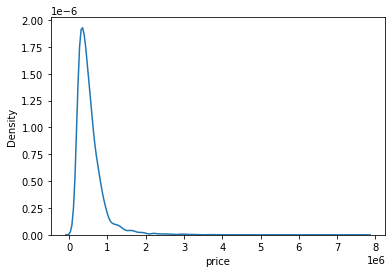

In [13]:
# y의 분포도 확인하기
sns.kdeplot(y)
plt.show()

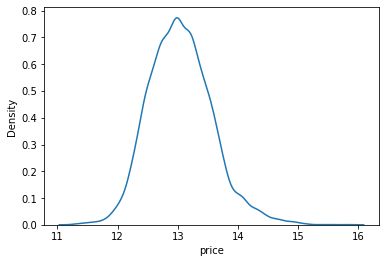

In [14]:
# 로그 사용해서 재정의하기
y = np.log1p(y)
sns.kdeplot(y)
plt.show()

In [15]:
# train과 test 다시 나눠주기
train = data.iloc[:train_len, :]
test = data.iloc[train_len:, :]

print(train.shape)
print(test.shape)
# train의 target값 y 인지하기
print(y)

(15035, 19)
(6468, 19)
0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64


# 모델링

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [17]:
# 나중에 y_test, y_pred에 적용한 np.log1p()를 되돌리기 위해 np.expm1() 사용
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [18]:
# lgbm 사용해서 학습하기
random_state = 15

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

print('ok')

ok


In [19]:
def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)

        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)

        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,133548.728652
RandomForestRegressor,131013.289475
XGBRegressor,124251.755245
LGBMRegressor,112626.145448


# GridSearch와 여러 모델에 하이퍼 파라미터 추가하기

In [20]:
from sklearn.model_selection import GridSearchCV

In [21]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=-1):
    # model 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                        cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # fitting
    grid_model.fit(train, y)
    
    # params, score 결과 저장하기
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 만들기
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값을 추가하고 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')
    
    return results

In [22]:
# LGBMRegressor
lgb_params = {
    'n_estimators' : [400, 800],
    'learning_rate' : [0.1, 0.05],
    'max_depth' : [8, 10, 15, 20]
}

lightgbm = LGBMRegressor(random_state=random_state)

my_GridSearch(lightgbm, train, y, lgb_params)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
11,0.05,10,800,-0.025903,0.160945
9,0.05,8,800,-0.025937,0.161050
13,0.05,15,800,-0.025941,0.161062
15,0.05,20,800,-0.026033,0.161347
10,0.05,10,400,-0.026036,0.161356
8,0.05,8,400,-0.026063,0.161441
12,0.05,15,400,-0.026088,0.161518
2,0.10,10,400,-0.026118,0.161609
14,0.05,20,400,-0.026157,0.161731
6,0.10,20,400,-0.026205,0.161881


In [23]:
# 적용한 하이퍼 파라미터 적합성 및 rmse 점수 확인
check_lightgbm = LGBMRegressor(learning_rate=0.05, max_depth=10, n_estimators=800)

check_X_train, check_X_test, check_y_train, check_y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
check_lightgbm.fit(check_X_train, check_y_train)

print(check_lightgbm.score(check_X_train, check_y_train))
print(check_lightgbm.score(check_X_test, check_y_test))

y_pred = check_lightgbm.predict(check_X_test)
check_rmse = rmse(check_y_test, y_pred)
check_rmse

0.9678598743905049
0.9163458682443472


106043.222713269

### target score 110000 이하이므로 제출하기!!

# 저장

In [24]:
def save_submission(model, train, y, test, model_name, rmsle):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/AI_study/Exploration/E05_kaggle_house_price_prediction/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('save{}'.format(submission_csv_path))

In [25]:
save_submission(check_lightgbm, train, y, test, model_name='lgbm', rmsle='0.160945')

save/aiffel/aiffel/AI_study/Exploration/E05_kaggle_house_price_prediction/data/submission_lgbm_RMSLE_0.160945.csv


# 결과
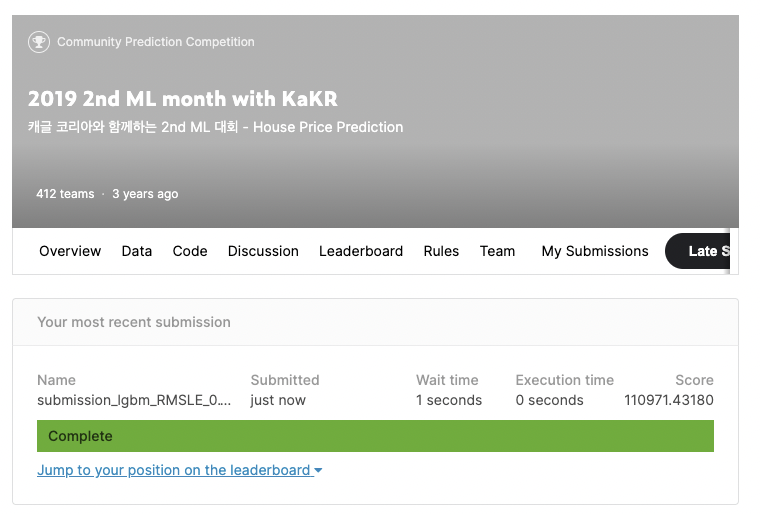   

약 1000점 over로 하이퍼 파라미터 값을 살짝 바꾼 뒤 다시 재출해야한다!!

---

# 1차 수정_하이퍼 파라미터 조정하기

수정 전 23번째 코드블럭 결과가
0.9678598743905049   
0.9163458682443472   
106043.222713269   
이렇게 나왔다 이는 과소적합에 해당하므로 훈련량을 늘리기 위해 cv를 5에서 10으로 수정   
그리고 하이퍼 파라미터에 num_leaves 추가하고 파라미터의 가지수 추가

In [26]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=-1):
    # model 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                        cv=10, verbose=verbose, n_jobs=n_jobs)
    
    # fitting
    grid_model.fit(train, y)
    
    # params, score 결과 저장하기
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 만들기
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값을 추가하고 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')
    
    return results

In [27]:
# LGBMRegressor
lgb_params = {
    'n_estimators' : [800, 1000, 1100],
    'learning_rate' : [0.05],
    'max_depth' : [8, 10, 15, 20],
    'num_leaves' : [15, 31]
}

lightgbm = LGBMRegressor(random_state=random_state)

my_GridSearch(lightgbm, train, y, lgb_params)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
[CV] END ...learning_rate=0.1, max_depth=8, n_estimators=400; total time=   0.9s
[CV] END ...learning_rate=0.1, max_depth=8, n_estimators=400; total time=   0.9s
[CV] END ...learning_rate=0.1, max_depth=8, n_estimators=400; total time=   0.9s
[CV] END ...learning_rate=0.1, max_depth=8, n_estimators=800; total time=   1.7s
[CV] END ...learning_rate=0.1, max_depth=8, n_estimators=800; total time=   1.8s
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=400; total time=   1.0s
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=400; total time=   1.5s
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=800; total time=   2.5s
[CV] END ..learning_rate=0.1, max_depth=15, n_estimators=400; total time=   0.9s
[CV] END ..learning_rate=0.1, max_depth=15, n_estimators=400; total time=   0.9s
[CV] END ..learning_rate=0.1, max_depth=15, n_estimators=400; total time=   1.3s
[CV] END ..learning_rate=0.1, max_depth=15, n_

[CV] END ...learning_rate=0.1, max_depth=8, n_estimators=400; total time=   1.5s
[CV] END ...learning_rate=0.1, max_depth=8, n_estimators=800; total time=   2.9s
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=400; total time=   1.4s
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=400; total time=   1.4s
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=800; total time=   2.4s
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=800; total time=   2.4s
[CV] END ..learning_rate=0.1, max_depth=15, n_estimators=400; total time=   1.4s
[CV] END ..learning_rate=0.1, max_depth=15, n_estimators=800; total time=   1.8s
[CV] END ..learning_rate=0.1, max_depth=15, n_estimators=800; total time=   1.8s
[CV] END ..learning_rate=0.1, max_depth=20, n_estimators=400; total time=   1.0s
[CV] END ..learning_rate=0.1, max_depth=20, n_estimators=400; total time=   0.9s
[CV] END ..learning_rate=0.1, max_depth=20, n_estimators=400; total time=   0.9s
[CV] END ..learning_rate=0.1

,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
4,0.05,8,1100,15,-0.025437,0.159491
2,0.05,8,1000,15,-0.025472,0.159600
10,0.05,10,1100,15,-0.025493,0.159667
16,0.05,15,1100,15,-0.025523,0.159758
22,0.05,20,1100,15,-0.025523,0.159758
8,0.05,10,1000,15,-0.025536,0.159800
14,0.05,15,1000,15,-0.025568,0.159901
20,0.05,20,1000,15,-0.025568,0.159901
0,0.05,8,800,15,-0.025617,0.160052
13,0.05,15,800,31,-0.025647,0.160147


In [28]:
# 적용한 하이퍼 파라미터 적합성 및 rmse 점수 확인
check_lightgbm = LGBMRegressor(learning_rate=0.05, max_depth=8, n_estimators=1100, num_leaves=15)

check_X_train, check_X_test, check_y_train, check_y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
check_lightgbm.fit(check_X_train, check_y_train)

print(check_lightgbm.score(check_X_train, check_y_train))
print(check_lightgbm.score(check_X_test, check_y_test))

y_pred = check_lightgbm.predict(check_X_test)
check_rmse = rmse(check_y_test, y_pred)
check_rmse

0.9549151348241123
0.9176424472200043


105471.33276457788

### target score 110000 이하이므로 제출하기!!

# 저장

In [29]:
def save_submission(model, train, y, test, model_name, rmsle):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/AI_study/Exploration/E05_kaggle_house_price_prediction/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('save{}'.format(submission_csv_path))

In [30]:
save_submission(check_lightgbm, train, y, test, model_name='lgbm', rmsle='0.159491')

save/aiffel/aiffel/AI_study/Exploration/E05_kaggle_house_price_prediction/data/submission_lgbm_RMSLE_0.159491.csv


# 결과
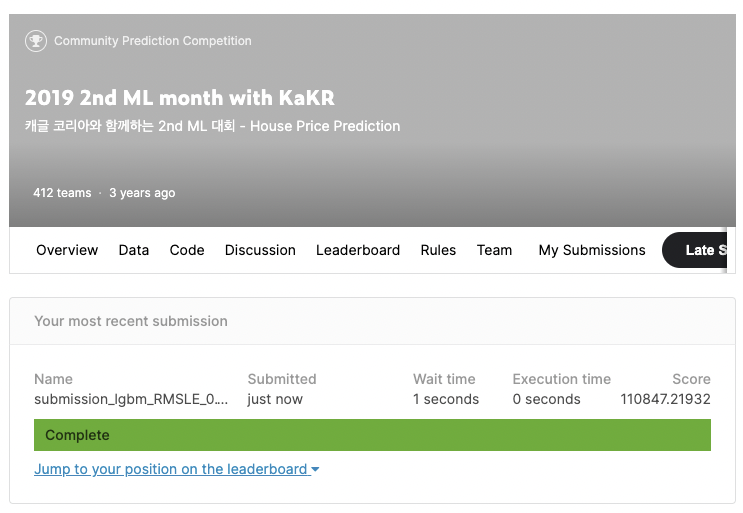   
크게 달라진건 없었다.

---

# 2차 수정_하이퍼 파라미터 조정하기

In [31]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=-1):
    # model 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                        cv=10, verbose=verbose, n_jobs=n_jobs)
    
    # fitting
    grid_model.fit(train, y)
    
    # params, score 결과 저장하기
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 만들기
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값을 추가하고 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')
    
    return results

In [32]:
# LGBMRegressor
lgb_params = {
    'n_estimators' : [800, 1600],
    'learning_rate' : [0.1],
    'max_depth' : [-1],
    'num_leaves' : [8, 15]
}

lightgbm = LGBMRegressor(random_state=random_state)

my_GridSearch(lightgbm, train, y, lgb_params)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
2,0.1,-1,1600,8,-0.025533,0.159790
1,0.1,-1,800,15,-0.025691,0.160284
0,0.1,-1,800,8,-0.025743,0.160447
3,0.1,-1,1600,15,-0.026150,0.161710


In [33]:
# 적용한 하이퍼 파라미터 적합성 및 rmse 점수 확인
check_lightgbm = LGBMRegressor(learning_rate=0.1, max_depth=-1, n_estimators=1600, num_leaves=8)

check_X_train, check_X_test, check_y_train, check_y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
check_lightgbm.fit(check_X_train, check_y_train)

print(check_lightgbm.score(check_X_train, check_y_train))
print(check_lightgbm.score(check_X_test, check_y_test))

y_pred = check_lightgbm.predict(check_X_test)
check_rmse = rmse(check_y_test, y_pred)
check_rmse

0.9605759885347183
0.9173365779365036


104413.46711271799

### target score 110000 이하이므로 제출하기!!

# 저장

In [34]:
def save_submission(model, train, y, test, model_name, rmsle):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/AI_study/Exploration/E05_kaggle_house_price_prediction/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('save{}'.format(submission_csv_path))

In [35]:
save_submission(check_lightgbm, train, y, test, model_name='lgbm', rmsle='0.159790')

save/aiffel/aiffel/AI_study/Exploration/E05_kaggle_house_price_prediction/data/submission_lgbm_RMSLE_0.159790.csv


# 결과

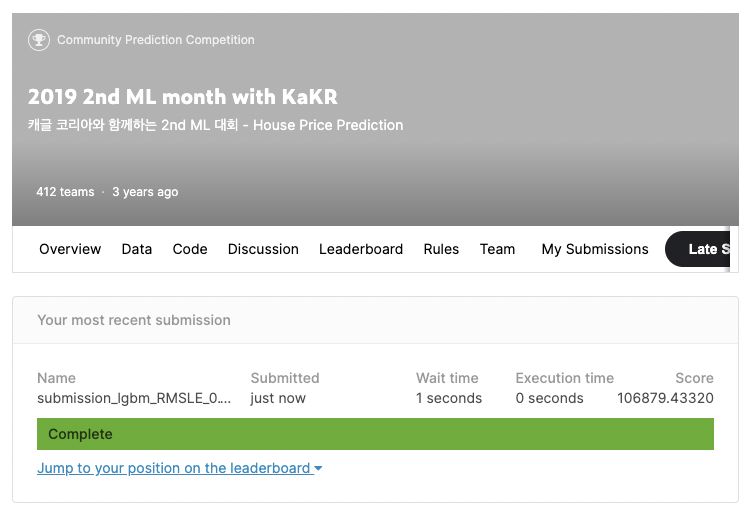   

목표 점수 110000 이하 달성!

---

# 회고

제공받은 데이터의 feature를 전처리하는 과정에서 price와의 상관관계를 확인 못한게 아쉽다.   
상관관계를 확인한 뒤 price에 영향을 주는 데이터들만 뽑아내서 모델 학습을 진행했다면 결과가 더 정확하지 않았을까 싶다.   
위에 부족한 점을 추가하려고 다른 작업물을 보면서 하다가 data와 sub를 concat하지 않고 진행했고 코드블럭들을 위, 아래 섞는 과정에서 결과물이 많이 꼬였음을 확인했다. 그래서 처음부터 다시 작성하면서 되돌아보기로 결정했다. ~~2022.01.23 1차 엎기~~   

데이터 전처리 하는 과정에서 `data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(int)`에 `int` 대신 `str`을 넣었다가 모델링 학습을 못하는 오류가 발생했다. 지금은 해결해서 다행이지만 간단한 버그 잡는데 시간을 많이 사용했다. 🥲   

다른 사람들은 어떻게 작업했는지 궁금해서 캐글을 통해 완성된 코드를 많이 봤는데, 특히 기억에 남는 작업물은 위도와 경도를 분석해서 좋은 환경에 있는 비싼 집을 묶어서 학습시키는 분도 계셨다. features를 어떻게 해석하냐에 따라서 처리 과정이 엄청 차이날 수 있음을 깨달았다. 그리고 내가 짜던 코드와 비슷한 방식으로 했지만 그분의 코드와 나의 코드를 합치는 작업이 어려웠다. 아직도 코드 해석과 코드끼리 접목시키는 능력이 많이 부족함을 느꼈다.

2022.01.23   
Score 110971로 약간의 수정 요망   

2022.01.24   
1차 수정 하이퍼 파라미터 수정해서 제출 Score 110847   
2차 수정 rmse가 최대한 낮은 하이퍼 파라미터 조합 만들어서 제출 Score 106879 __목표 점수 달성 완료__   